In [23]:
%autoreload 2

In [20]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)


from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdmn


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer
from src.fitness_features_preprocessing import NGRAM_SCORE_PATTERN

In [2]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
# real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))

# regrown_game_asts = list(cached_load_and_parse_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl', grammar_parser, True, relative_path='..'))


In [3]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
print(fitness_df.shape)
original_game_counts = fitness_df.groupby('original_game_name').src_file.count().value_counts()
if len(original_game_counts) == 1:
    print(f'All original games have {original_game_counts.index[0] - 1} regrowths')
else:
    print('Some original games have different numbers of regrowths: {original_game_counts}')
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']
(100450, 392)
All original games have 1024 regrowths


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.969698,0.980189,0.972097,0.982683,0.983234,0.984843,0.941296,0.930606,0.994540,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.986488,0.985033,0.968718,0.980055,0.979109,0.985450,0.923794,0.930399,0.947819,0.953640
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.948358,0.973556,0.000000,0.000000,0.000000,0.000000,0.864027,0.869713,0.939114,0.951486
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.987400,0.980873,0.000000,0.000000,0.000000,0.000000,0.941296,0.930606,0.994540,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.985927,0.981736,0.000000,0.000000,0.000000,0.000000,0.978163,0.977679,0.974040,0.979537


In [4]:
POSITIVES_FILE = 'interactive-beta.pddl'
NEGATIVES_FILE = 'ast-real-regrowth-samples-1024.pddl'

def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = (POSITIVES_FILE, NEGATIVES_FILE),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [5]:
print(filtered_fitness_df.shape)
filtered_fitness_df.head()

(98, 392)


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.969698,0.980189,0.972097,0.982683,0.983234,0.984843,0.941296,0.930606,0.994540,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.986488,0.985033,0.968718,0.980055,0.979109,0.985450,0.923794,0.930399,0.947819,0.953640
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.948358,0.973556,0.000000,0.000000,0.000000,0.000000,0.864027,0.869713,0.939114,0.951486
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.987400,0.980873,0.000000,0.000000,0.000000,0.000000,0.941296,0.930606,0.994540,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.985927,0.981736,0.000000,0.000000,0.000000,0.000000,0.978163,0.977679,0.974040,0.979537


In [6]:
filtered_fitness_df[(filtered_fitness_df.real == 1) & (filtered_fitness_df.two_number_operation_found == 1)]

,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score


In [13]:
from latest_model_paths import LATEST_FITNESS_FEATURIZER_PATH, LATEST_FITNESS_FUNCTION_DATE_ID
from src.fitness_features import *

def _load_pickle_gzip(path: str):
    with gzip.open(path, 'rb') as f:
        return pickle.load(f)

fitness_featurizer = _load_pickle_gzip(LATEST_FITNESS_FEATURIZER_PATH)
fitnes_function, feature_names = utils.load_model_and_feature_columns(LATEST_FITNESS_FUNCTION_DATE_ID)
real_game_feafure_dicts = [fitness_featurizer.parse(ast, return_row=True) for ast in game_asts]
real_game_feature_lists = [[fd[name] for name in feature_names] for fd in real_game_feafure_dicts]
real_game_feature_vectors = [np.array(fl, dtype=float) for fl in real_game_feature_lists]

In [17]:
PCA_N_DIM = 32
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', random_state=SEED)

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None):

    if pca_kwargs is None:
        pca_kwargs = PCA_KWARGS
    else:
        temp_kwargs = PCA_KWARGS.copy()
        temp_kwargs.update(pca_kwargs)
        pca_kwargs = temp_kwargs

    if tsne_kwargs is None:
        tsne_kwargs = TSNE_KAWRGS

    else:
        temp_kwrags = TSNE_KAWRGS.copy()
        temp_kwrags.update(tsne_kwargs)
        tsne_kwargs = temp_kwrags

    if data.ndim > 2:
        data = data.reshape(-1, data.shape[-1])

    pca = PCA(n_components=pca_n_dim, **pca_kwargs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data_pca)

    return data_tsne


tsne_results = pca_and_tsne(np.array(real_game_feature_vectors))

In [34]:
is_throwing = np.array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True, False, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False])


game_types = np.array(['throwing', 'throwing', 'building', 'throwing', 'throwing',
       'throwing', 'throwing', 'throwing', 'building', 'throwing',
       'throwing', 'throwing', 'building_throwing', 'throwing',
       'building', 'throwing', 'building_throwing', 'throwing',
       'throwing', 'throwing', 'throwing', 'organizing', 'throwing',
       'organizing', 'throwing', 'building_throwing', 'organizing',
       'throwing', 'throwing', 'throwing', 'throwing', 'throwing',
       'throwing', 'organizing', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', 'building_organizing_throwing', 'throwing',
       'organizing', 'throwing', 'throwing', 'organizing', 'building',
       'throwing', 'throwing', 'organizing', 'building', 'throwing',
       'building_throwing', 'throwing', 'building', 'throwing',
       'organizing', 'throwing', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', 'throwing', 'throwing', 'organizing',
       'throwing', 'throwing', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', '', 'throwing', 'throwing', 'throwing',
       'throwing', 'throwing', 'building', 'throwing', 'throwing',
       'throwing', 'organizing'], dtype=object)

unique_game_types = set(game_types)
game_types_code = {t: i for i, t in enumerate(unique_game_types)}
game_types_list = [game_types_code[t] for t in game_types]

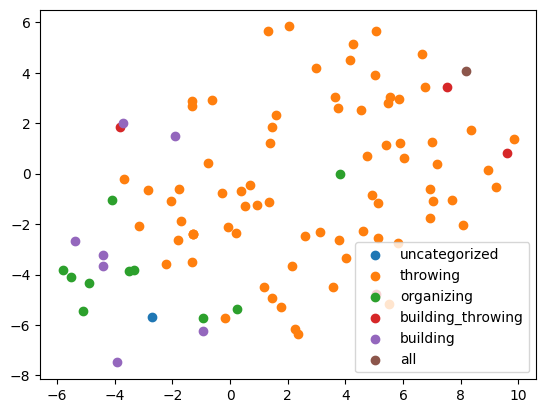

In [42]:
for game_type in unique_game_types:
    indices = np.where(game_types == game_type)[0]
    if not game_type:
        game_type = 'uncategorized'
    if game_type == 'building_organizing_throwing':
        game_type = 'all'
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=game_type)

plt.legend(loc='best')
plt.show()

In [7]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == NEGATIVES_FILE].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In nan% of the games, the regrown game was identical to the original game.


/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_69917/2713468933.py:6: RuntimeWarning: invalid value encountered in long_scalars
  unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)


In [ ]:
feature_columns = [str(c) for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]

remove_all_ngram_scores = []  #  ('full',)
for score_type in ('full', 'setup', 'constraints', 'terminal', 'scoring'):
    col_names = [c for c in feature_columns if c.startswith(f'ast_ngram_{score_type}') and c.endswith('_score')]

    if score_type not in remove_all_ngram_scores:
        col_names = col_names[:-1]

    for col in col_names:
        feature_columns.remove(col)

other_features = ['all_variables_defined', 'all_variables_used',
    'starts_and_ends_once',  # 'setup_objects_used',
    'all_preferences_used', 'no_adjacent_same_modal', 'adjacent_once_found',
    'repeated_variables_found', 'nested_logicals_found', 'identical_logical_children_found', 
    'no_two_number_operations', 'tautological_expression_found', 'redundant_expression_found',]

# Next up: compositionality_structure_, max_depth, mean_depth_, node_count_, predicate_under_modal_, max_number_variables_types_quantified_, max_quantification_count_, _arg_types_, length_of_then_modals_
prefixes = ['section_', 'pref_forall_', 'compositionality_structure_', 'max_depth_', 'mean_depth_']

feature_columns = [c for c in feature_columns if 'score' in c or any(c.startswith(prefix) for prefix in prefixes) or c in other_features]
feature_columns_set = set(feature_columns)

fake_games = filtered_fitness_df[filtered_fitness_df.src_file == NEGATIVES_FILE].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop([c for c in broadcasted_original.columns if c not in feature_columns_set], axis=1) - fake_games.drop([c for c in fake_games.columns if c not in feature_columns_set], axis=1))

if 'index' in original_regrown_diffs.columns:
    original_regrown_diffs = original_regrown_diffs.drop('index', axis=1)

unchanged_games_prop = (original_regrown_diffs == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In [ ]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

print(sum(never_change))

In [ ]:
mean_features_by_real = filtered_fitness_df[['real'] + [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]].groupby('real').mean()
feature_diffs = mean_features_by_real.loc[1] - mean_features_by_real.loc[0]
abs_diffs = feature_diffs.abs()

# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Change the random seed?
* See if the GPU is faster
* Try a different from of regularization?



In [ ]:
def get_features_by_abs_diff_threshold(diffs: pd.Series, score_threshold: float):
    feature_columns = list(diffs[diffs >= score_threshold].index)

    remove_all_ngram_scores = []  
    for score_type in ('full', 'setup', 'constraints', 'terminal', 'scoring'):
        col_names = sorted([c for c in feature_columns if c.startswith(f'ast_ngram_{score_type}') and c.endswith('_score')])

        if score_type not in remove_all_ngram_scores:
            col_names = col_names[:-1]

        for col in col_names:
            feature_columns.remove(col)

    return feature_columns

In [ ]:
BETA = 1.0

test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_loss, utils.fitness_softmin_loss_positive_to_all_negatives], # [utils.fitness_hinge_loss_with_cross_example],
        # 'fitness__weight_decay': [0.0],  
        # 'fitness__margin': [8, 16],
        'fitness__beta': [BETA], #   [4, 8],
        'fitness__lr': [4e-3, 1e-3, 3e-4],  #  [1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [256, 512, 1024],  # [256, 512, 1024],  # 128
        'fitness__batch_size': [1, 2, 4, 8, 16]  # , 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        # 'fitness__dataset_energy_beta': [1, 3, 5],
        # 'fitness__regularization_weight': [0.01, 0.05],
    },
]

def build_regularization_function(ord: int = 1, threshold: float = 0):
    def regularization_function(model: nn.Module) -> torch.Tensor:
        w = model.fc1.weight.squeeze()  # type: ignore
        return torch.linalg.norm(w * (w.abs() >= threshold), ord)
    
    return regularization_function

regularizer = build_regularization_function(ord=1, threshold=0)

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(
    negative_score_reduction='none', 
    n_epochs=20000, patience_epochs=200, 
    bias_init_margin_ratio=0.01,
    device=torch.device('cuda:0'), 
    # regularizer=regularizer,
    shuffle_negatives=True, 
    split_validation_from_train=True,
    evaluate_opposite_shuffle_mode=False,
    full_dataset_on_device=True,
    # use_lr_scheduler=True,
    )
cv_kwargs = dict(refit='loss', error_score='raise')  # , n_jobs=6)  # , n_jobs=1)
scoring = utils.build_multiple_scoring_function(
    [utils.wrap_loss_function_to_metric(utils.fitness_sofmin_loss_positive_negative_split, dict(beta=BETA), True),  # type: ignore
     utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank, utils.evaluate_fitness_single_game_min_rank, 
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.01), True),  # type: ignore
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.05), True),  # type: ignore
     ],
    ['loss', 'overall_ecdf', 'single_game_rank', 'single_game_min_rank', 'energy_of_negative@1%', 'energy_of_negative@5%'],
)

score_threshold = 0.02

mean_features_by_real = filtered_fitness_df[['real'] + [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]].groupby('real').mean()
feature_diffs = mean_features_by_real.loc[1] - mean_features_by_real.loc[0]
abs_diffs = feature_diffs.abs()
feature_columns = get_features_by_abs_diff_threshold(abs_diffs, score_threshold)

# remove_all_ngram_scores = []  #  ('full',)
# for score_type in ('full', 'setup', 'constraints', 'terminal', 'scoring'):
#     col_names = [c for c in feature_columns if c.startswith(f'ast_ngram_{score_type}') and c.endswith('_score')]

#     if score_type not in remove_all_ngram_scores:
#         col_names = col_names[:-1]

#     for col in col_names:
#         feature_columns.remove(col)

# other_features = ['all_variables_defined', 'all_variables_used',
#     'starts_and_ends_once', 'setup_objects_used',
#     'all_preferences_used', 'no_adjacent_same_modal', 'adjacent_once_found',
#     'repeated_variables_found', 'nested_logicals_found', 'identical_logical_children_found', 
#     'no_two_number_operations', 'tautological_expression_found', 'redundant_expression_found',]


# Next up: compositionality_structure_, max_depth, mean_depth_, node_count_, predicate_under_modal_, max_number_variables_types_quantified_, max_quantification_count_, _arg_types_, length_of_then_modals_
# prefixes = ['section_', 'pref_forall_', 'compositionality_structure_', 'max_depth_', 'mean_depth_']  #  
# middles = ['score']

# feature_columns = [c for c in feature_columns if any(middle in c for middle in middles) or any(c.startswith(prefix) for prefix in prefixes) or c in other_features]
# feature_columns = [c for c in feature_columns if 'score' in c or c.startswith('section_')]

cv, (train_tensor, test_tensor), results = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid, feature_columns=feature_columns,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    # energy_weighted_resampling=True, 
    # random_seed=121,
    )

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, results, title_note='feature search')

In [ ]:
with gzip.open('../data/fitness_cv/fitness_sweep_fixed_features_2023_03_22_2.pkl.gz', 'rb') as f:
    fitness_sweep = pickle.load(f)


cv = fitness_sweep['cv']
train_tensor = fitness_sweep['train_tensor']
test_tensor = fitness_sweep['test_tensor']
results = fitness_sweep['results']
feature_columns = fitness_sweep['feature_columns']

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, results, title_note='latest sweep')

In [ ]:
FIT_ON_FULL_DATA = True
SAVE_MODEL = True


if FIT_ON_FULL_DATA:
    full_tensor = utils.df_to_tensor(fitness_df, feature_columns)
    cv.best_estimator_['fitness'].train_kwargs['split_validation_from_train'] = False
    cv.best_estimator_.fit(full_tensor)
    print(utils.evaluate_trained_model(cv.best_estimator_, full_tensor))

if SAVE_MODEL:
    utils.save_model_and_feature_columns(cv, feature_columns)
    

In [ ]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.squeeze().detach().cpu()

K = 15
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('**Features with largest negative weights (most real):**')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('\n**Features with largest positive weights (most fake):**')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


In [ ]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.squeeze().detach().cpu()
weight_indices = torch.argsort(weights)
found_positive = False

lines = ['**Feature Weights (ascending):**\n']
for i, idx in enumerate(weight_indices):
    lines.append(f'{i:>2}.  {feature_columns[idx]} = {weights[idx].item():.3f}')
    if not found_positive and weights[weight_indices[i + 1]] > 0:
        found_positive = True
        lines.append('----')

display(Markdown('\n'.join(lines)))


In [ ]:
filtered_fitness_df[(filtered_fitness_df.real == 1) & (filtered_fitness_df.section_without_pref_or_total_count_terminal > 0)]

In [ ]:
gb = filtered_fitness_df.groupby('real')[[c for c in filtered_fitness_df.columns if 'max_quantification_count_' in c]].mean()
np.abs(gb.loc[1] - gb.loc[0]).mean() * (98 * 1024)

In [ ]:
filtered_fitness_df.groupby('real').section_without_pref_or_total_count_scoring.sum()

In [ ]:
filtered_fitness_df.groupby('real').section_without_pref_or_total_count_terminal.sum()

In [ ]:
[(c, weights[feature_columns.index(c)].item()) for c in feature_columns if 'exists' in c]

In [ ]:
FIT_ON_FULL_DATA = True
SAVE_MODEL = True


if FIT_ON_FULL_DATA:
    full_tensor = utils.df_to_tensor(fitness_df, feature_columns)
    cv.best_estimator_['fitness'].train_kwargs['split_validation_from_train'] = False
    cv.best_estimator_.fit(full_tensor)
    print(utils.evaluate_trained_model(cv.best_estimator_, full_tensor))

if SAVE_MODEL:
    utils.save_model_and_feature_columns(cv, feature_columns)

## Systematic evaluation without cross-validation

In [ ]:
scaler_kwargs = dict(passthrough=True)
model_kwargs = dict()
train_kwargs = dict(
    loss_function=utils.fitness_softmin_loss,
    k=1024,
    lr=1e-2,
    beta=4.0, 
    negative_score_reduction='none', 
    n_epochs=3000, 
    shuffle_negatives=True, 
    bias_init_margin_ratio=0.01,
    # device=torch.device('cuda:0'), 
    # regularizer=regularizer,
    split_validation_from_train=True,
    )

sweep_param_grid = dict(
    patience_epochs=range(10, 60, 10),
    use_lr_scheduler=[False, True],
    batch_size=[1, 2, 4, 8, 16],
    score_threshold=[0, 0.005, 0.01, 0.02, 0.03, 0.04],
)

scoring = utils.build_multiple_scoring_function(
    [utils.wrap_loss_function_to_metric(utils.fitness_sofmin_loss_positive_negative_split, dict(beta=BETA), True),
     utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank, utils.evaluate_fitness_single_game_min_rank, 
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.01), True),
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.05), True),
     ],
    ['loss', 'overall_ecdf', 'single_game_rank', 'single_game_min_rank', 'energy_of_negative@1%', 'energy_of_negative@5%'],
)

mean_features_by_real = filtered_fitness_df[['real'] + [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]].groupby('real').mean()
feature_diffs = mean_features_by_real.loc[1] - mean_features_by_real.loc[0]
abs_diffs = feature_diffs.abs()

sweep_models = {}
sweep_results = {}

for (patience_epochs, use_lr_scheduler, batch_size, score_threshold) in tqdm.tqdm(itertools.product(*sweep_param_grid.values())):
    setting_train_kwargs = train_kwargs.copy()
    setting_train_kwargs.update(dict(patience_epochs=patience_epochs, use_lr_scheduler=use_lr_scheduler, batch_size=batch_size))

    feature_columns = list(abs_diffs[abs_diffs >= score_threshold].index)

    remove_all_ngram_scores = []  
    for score_type in ('full', 'setup', 'constraints', 'terminal', 'scoring'):
        col_names = [c for c in feature_columns if c.startswith(f'ast_ngram_{score_type}') and c.endswith('_score')]

        if score_type not in remove_all_ngram_scores:
            col_names = col_names[:-1]

        for col in col_names:
            feature_columns.remove(col)

    model, _, results = utils.initialize_and_fit_model(
        fitness_df, split_test_set=True, feature_columns=feature_columns,
        random_seed=DEFAULT_RANDOM_SEED,
        scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=setting_train_kwargs,
        # energy_weighted_resampling: bool = False, 
        # train_prop: float = DEFAULT_TRAINING_PROP,
        scoring_function=scoring, 
    )

    setting_key = (patience_epochs, use_lr_scheduler, batch_size, score_threshold, len(feature_columns))
    sweep_models[setting_key] = model
    sweep_results[setting_key] = results


KEY_HEADERS = ['patience_epochs', 'use_lr_scheduler', 'batch_size', 'score_threshold', 'n_features']
example_values = next(iter(sweep_results.values()))
VALUE_HEADERS = [f'{outer_key}_{inner_key}' for outer_key in example_values for inner_key in example_values[outer_key]]

rows = [list(key) + [results[outer_key][inner_key] for outer_key in results for inner_key in results[outer_key]]
        for key, results in sweep_results.items()]

sweep_results_df = pd.DataFrame(rows, columns=KEY_HEADERS + VALUE_HEADERS)
sweep_results_df = sweep_results_df.assign(**{c: sweep_results_df[c].abs() for c in sweep_results_df.columns if 'ecdf' in c or 'loss' in c}, use_lr_scheduler=sweep_results_df.use_lr_scheduler.astype(int)
sweep_results_df.head()



In [ ]:
NAME_MAPPINGS = {
    'patience_epochs': 'Patience Epochs',
    'n_features': '# of Features Used',
    'use_lr_scheduler': 'Use LR Scheduler',
    'batch_size': 'Batch Size',
    'train_ecdf': 'Train ECDF',
    'test_ecdf': 'Test ECDF',
    'train_game_rank': 'Train Game Rank',
    'test_game_rank': 'Test Game Rank',
}


def plot_sweep_results(
    results_df: pd.DataFrame, 
    x_key: str, 
    color_by_key: str,
    column_by_key: typing.Optional[str] = None,
    row_by_key: typing.Optional[str] = None,
    filter_conditions: typing.Optional[typing.Dict[str, typing.Any]] = None,
    legend_ax_index: int = 0,
    name_mappings: typing.Dict[str, str] = NAME_MAPPINGS,
    metrics: typing.List[str] = ['train_overall_ecdf', 'test_overall_ecdf'],
    cmap_name: str = 'tab20',
    ylabel: typing.Optional[str] = None,
    subplot_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    suptitle: typing.Optional[str] = None,
    ):

    color_values = list(sorted(results_df[color_by_key].unique()))
    x_values = list(sorted(results_df[x_key].unique()))

    column_values = []
    if column_by_key is not None:
        column_values = list(sorted(results_df[column_by_key].unique()))

    row_values = []
    if row_by_key is not None:
        row_values = list(sorted(results_df[row_by_key].unique()))

    if filter_conditions is not None:
        row_filter = np.ones(len(results_df), dtype=bool)
        for col, val in filter_conditions.items():
            row_filter &= (results_df[col] == val)

        df = results_df[row_filter]
    else:
        df = results_df


    groupby_fields = []
    n_rows = n_columns = 1

    if row_by_key is not None:
        groupby_fields.append(row_by_key)
        n_rows = len(row_values)

    if column_by_key is not None:
        groupby_fields.append(column_by_key)
        n_columns = len(column_values)
        
    groupby_fields.append(color_by_key)
    groupby_fields.append(x_key)    
    results_groupby = df.groupby(groupby_fields)[metrics].mean()

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(6 * n_columns, 4 * n_rows), squeeze=False)
    cmap = plt.get_cmap(cmap_name)

    for row_index, row_axes in enumerate(axes):
        row_value = None if row_by_key is None else row_values[row_index]
        for col_index, ax in enumerate(row_axes):
            col_value = None if column_by_key is None else column_values[col_index]
            
            for color_index, color_value in enumerate(color_values):
                key = []
                if row_value is not None: key.append(row_value)
                if col_value is not None: key.append(col_value)
                key.append(color_value)

                for metric_index, metric in enumerate(metrics):
                    y_values = [results_groupby.loc[tuple(key + [x])][metric] for x in x_values]
                    ax.plot(x_values, y_values, marker='o', linestyle='--', linewidth=2, 
                            color=cmap(color_index * len(metrics) + metric_index), 
                            label=name_mappings.get(color_value, color_value) if metric_index == 0 else None)

            ax.set_xlabel(name_mappings.get(x_key, x_key))
            if col_index == 0: ax.set_ylabel(ylabel if ylabel is not None else name_mappings.get(metrics[0], metrics[0]))
            ax.set_xticks(x_values)
            ax.set_xticklabels(x_values)
            if (row_index * n_columns) + col_index  == legend_ax_index: ax.legend()
            if column_by_key is not None: ax.set_title(f'{name_mappings.get(column_by_key, column_by_key)}={col_value}')

    ylim_min = min(ax.get_ylim()[0] for ax in itertools.chain.from_iterable(axes))
    ylim_max = max(ax.get_ylim()[1] for ax in itertools.chain.from_iterable(axes))
    for ax in itertools.chain.from_iterable(axes):
        ax.set_ylim(ylim_min, ylim_max)

    if subplot_adjust_params is not None:
        plt.subplots_adjust(**subplot_adjust_params)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)



In [ ]:
plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='use_lr_scheduler',
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Scheduler')

plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='use_lr_scheduler',
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Scheduler')

In [ ]:
plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='batch_size',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Batch Size')

plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='batch_size',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Batch Size')

In [ ]:
plot_sweep_results(sweep_results_df, 'n_features', 'batch_size', 
    column_by_key='patience_epochs',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Patience Epochs')


plot_sweep_results(sweep_results_df, 'n_features', 'batch_size', 
    column_by_key='patience_epochs',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Patience Epochs')


### Checking the effect of regrowth depth

In [ ]:
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]
full_binarized_tensor = utils.df_to_tensor(binarized_df, feature_columns)
full_tensor_scores = cv_no_scaling_sq_sq.best_estimator_.transform(full_binarized_tensor).detach()

In [ ]:
energy_diffs = full_tensor_scores[:, 1:] - full_tensor_scores[:, 0].unsqueeze(1)
energy_diffs.ravel().shape

In [ ]:
def extract_regrowth_depth(game_text: str):
    game_id_start = game_text.find('(game')
    game_id_section = game_text[game_id_start:game_text.find(')', game_id_start)]
    regrowth_depth = game_id_section[game_id_section.rfind('-') + 2:]
    return int(regrowth_depth)

regrowth_depts = [extract_regrowth_depth(g) for g in regrown_game_texts]

In [ ]:
plt.scatter(regrowth_depts, energy_diffs.ravel().numpy(), s=5)

In [ ]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling_sq_sq.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

In [ ]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games, square-square loss'

train_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

In [ ]:
weight_threshold = 1
weights = cv_no_scaling_sq_sq.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
weights_above_threshold = (weights.abs() > weight_threshold).numpy()
feature_columns = [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
features_with_weight_above_threshold = [feature_columns[i] for i in range(len(feature_columns)) if weights_above_threshold[i]]

with open('../data/features_with_weight_above_threshold_2022_01_24.txt', 'w') as f:
    f.write('\n'.join(features_with_weight_above_threshold))
    


In [ ]:
full_binarized_tensor = utils.df_to_tensor(binarized_df, [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS])
test_negative_scores_tensor = torch.tensor(test_negative_scores)
test_positive_scores_tensor = torch.tensor(test_positive_scores)
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]

In [ ]:
torch.topk((test_negative_scores_tensor - test_positive_scores_tensor.unsqueeze(-1)).ravel(), 30, largest=False)

In [ ]:
test_negative_scores_tensor.ravel()[836] == test_negative_scores_tensor[836 // 64, 836 % 64]

In [ ]:
fitness_df[(fitness_df.real == 1) & (fitness_df.all_variables_used == 0)]

In [ ]:
from argparse import Namespace
from src.fitness_features import *
# from src.fitness_ngram_models import TextNGramModel, TextMultiNGramModel, ASTMultiNGramModel, NGramASTParser

# with gzip.open('../models/fitness_featurizer_2023_02_02.pkl.gz', 'rb') as f:
#     featurizer = pickle.load(f)
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED


In [ ]:
args = Namespace(no_binarize=False, no_merge=False, use_specific_objects_ngram_model=False)
featurizer = build_fitness_featurizer(args)

# featurizer = build_behavioral_features_featurizer(BASIC_BINNED)

In [ ]:
np.seterr(all='raise')
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]
# _ = [featurizer.parse(regrown_game_asts[i], return_row=False) for i in tqdmn.trange(len(regrown_game_asts))]

In [ ]:
d = featurizer.to_df()

In [ ]:
thresholds = [2.0, 3.0, 4.0, 10]
right = True
bins = np.digitize(d.max_width_constraints, thresholds, right)
np.unique(bins, return_counts=True)



In [ ]:
d[['node_count', 'unique_objects_referenced', 'unique_predicates_referenced']].quantile(np.linspace(0.1, 1, 10))

In [ ]:
d.plot(x='unique_objects_referenced', y='unique_predicates_referenced', kind='scatter')

In [ ]:
d.plot(y='node_count', kind='hist')

In [ ]:
d = d.assign(original_game_name=d.game_name)  # real=fitness_df.src_file == 'interactive-beta.pddl',
d.original_game_name.where(
    d.game_name.apply(lambda s: (s.count('-') <= 1) or (s.startswith('game-id') and s.count('-') >= 2)),
    d.original_game_name.apply(lambda s: s[:utils._find_nth(s, '-', 2)]),
    inplace=True)

In [ ]:
d.redundant_scoring_terminal_expression_found.describe()

In [ ]:
score_threshold = 0.02

mean_features_by_real = filtered_fitness_df[['real'] + [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]].groupby('real').mean()
feature_diffs = mean_features_by_real.loc[1] - mean_features_by_real.loc[0]
abs_diffs = feature_diffs.abs()
feature_columns = get_features_by_abs_diff_threshold(abs_diffs, score_threshold)

In [ ]:
for i in range(len(game_asts)):
    row = typing.cast(dict, featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=True, preprocess_row=True))
    df_row = d[d.game_name == row['game_name']]
    for key in row:
        if key in df_row and row[key] != df_row[key].values[0]:
            print(f'In game {row["game_name"]}, {key} mismatch: {row[key]} != {df_row[key].values[0]}')

        elif key not in df_row:
            print(f'In game {row["game_name"]}, {key} not in df')

In [ ]:
d[d.game_name == '6172feb1665491d1efbce164-0']['real'].values[0]

In [ ]:
zero_sum_features = []
positive_mean_features = []

for feature in feature_columns:
    if feature not in d.columns:
        continue

    if any(x in feature for x in ('arg_types', 'predicate_under_modal', 'max_number', 'max_quantification', 'compositionality_structure', 'depth', 'node_count')):
        continue

    if d.loc[d.real == True, feature].sum() == 0:
        zero_sum_features.append(feature)
    else:
        positive_mean_features.append(feature)

print(f'Zero sum features: {zero_sum_features}')
print(f'Positive sum features: {positive_mean_features}')

In [ ]:
d[[c for c in d.columns if 'max_q' in c]].describe()

In [ ]:
for original_game_name in d.original_game_name.unique():
    original_game_scoring_score = d[d.game_name == original_game_name].ast_ngram_scoring_n_5_score.max()
    sub_frame = d.loc[(d.original_game_name == original_game_name) & (d.real == 0) & (d.ast_ngram_scoring_n_5_score > original_game_scoring_score), 'ast_ngram_scoring_n_5_score']
    if len(sub_frame) > 0:
        print(original_game_name)
        print(sub_frame)


In [ ]:
d.groupby('real').ast_ngram_scoring_n_5_score.describe()

In [ ]:
d[d.section_exists_setup == 0].ast_ngram_setup_n_5_score.value_counts()

In [ ]:
!ls -la /tmp/gd1279/fitness_features

In [ ]:
d = featurizer.to_df()
temp_df = pd.read_csv('/tmp/gd1279/fitness_features/fitness_features_1024_regrowths.csv.gz_0.temp.csv')
temp_df.columns = d.columns
temp_df = utils._add_original_game_name_column(temp_df)
d = utils._add_original_game_name_column(d)
temp_df.head()

In [ ]:
for original_game_name in d.original_game_name.unique()[1:]:
    original_game_scoring_score = d[d.game_name == original_game_name].ast_ngram_scoring_n_5_score.max()
    if original_game_scoring_score == 0:
        print(original_game_name)
        sub_frame = temp_df.loc[(temp_df.original_game_name == original_game_name) & (temp_df.real == 0) & (temp_df.ast_ngram_scoring_n_5_score > original_game_scoring_score),
                                ['game_name', 'original_game_name', 'ast_ngram_scoring_n_5_score']]
        if len(sub_frame) > 0:
            print(original_game_name, len(sub_frame))
            break

In [ ]:
sub_frame.head()

In [ ]:
game_index = 65
negative_index = 470

pos_r = featurizer.parse(game_asts[game_index], 'test.pddl', return_row=True, preprocess_row=False)
neg_r = featurizer.parse(regrown_game_asts[game_index * 1024 + negative_index], 'test.pddl', return_row=True, preprocess_row=False)

In [ ]:
with open('../models/ast_7_ngram_model_2023_03_06.pkl', 'rb') as f:
    ngram_model = pickle.load(f)


In [ ]:
from ast_parser import ASTParentMapper
parent_mapper = ASTParentMapper()
parent_mapper(game_asts[game_index])

In [ ]:
r = featurizer.parse(game_asts[17], 'test.pddl', return_row=True, preprocess_row=False)

In [ ]:
{k: v for k, v in r.items() if k.startswith('section_without')}